In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import warnings
warnings.filterwarnings('ignore')

### Import packages

In [10]:
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


In [29]:
import pandas as pd

import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

In [12]:
from src.preprocess import  preprocess
from src.utils import get_tokens
from src.model import MeanEmbeddingVectorizer

from src.model import cross_validate_models
from src.utils import plot_model_performance, plot_confusion_matrix

In [13]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/kazi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kazi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/kazi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kazi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
sns.set_style('white')

### Provide data path

In [15]:
DATA_SOURCE = './data'

In [16]:
DATA_PATH = Path(f'../{DATA_SOURCE}')
DATA_PATH

PosixPath('../data')

### Read the data

In [17]:
df= pd.read_csv(DATA_PATH/'ds_chats_data.csv',)

In [18]:
df.head()

,BODY,REASON,DETAILED_REASON,AGENT_TYPE
0,"Sam (SumUp bot): Hi there. I&#39;m Sam, SumUp&...",Other questions about product usage,SumUp Card,Human
1,"Sam (SumUp bot): Hi there. I&#39;m Sam, SumUp&...",Other questions about product usage,SumUp Card,Human
2,") Sam (SumUp bot): Hi there. I&#39;m Sam, SumU...",Other questions about product usage,SumUp Card,Human
3,"Sam (SumUp bot): Hi there. I&#39;m Sam, SumUp&...",Other questions about product usage,SumUp Card,Human
4,"Sam (SumUp bot): Hi there. I&#39;m Sam, SumUp...",Other questions about product usage,Business Accounts,Human


In [19]:
df.groupby(["AGENT_TYPE","REASON"]).count()

BODY  DETAILED_REASON
AGENT_TYPE REASON                                                    
Bot        \N                                    674              674
Human      Blocked/defective readers             551              551
           Bookkeeping                           145              145
           Fee negotiation                        62               62
           Other                                 741              741
           Other questions about product usage   476              476
           Other technical issues                501              501
           Pre-Signup                            148              148
           Product setup/activation              628              628
           Profile/account/store closure         285              285
           Signup                                387              387

In [20]:
df['word_count'] = df['BODY'].apply(lambda x: len(str(x).split()))

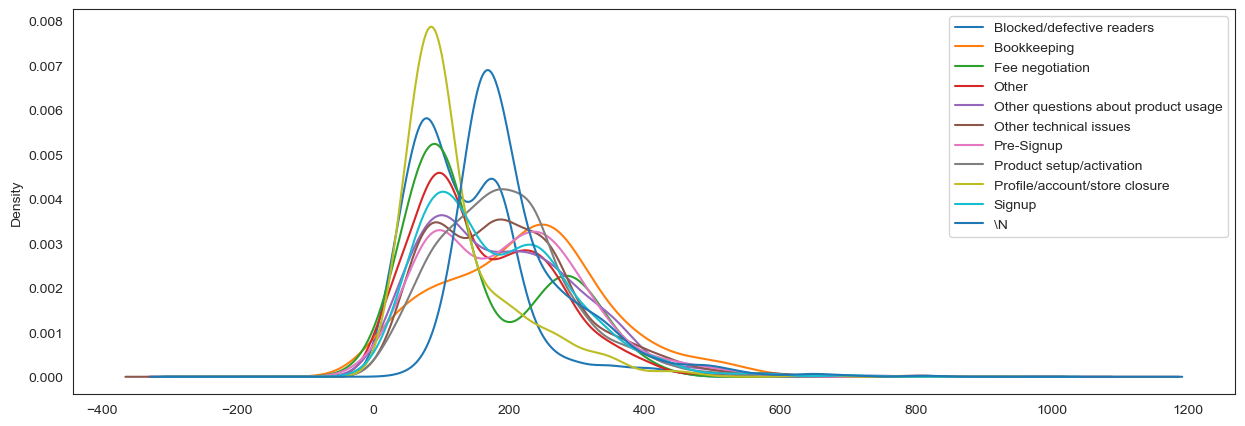

In [21]:
fig, ax = plt.subplots(1,figsize=(15,5))
df.groupby('REASON')['word_count'].plot(kind='kde',ax=ax);
plt.legend()

In [22]:
%%time
df['clean_text'] = df['BODY'].apply(lambda x: preprocess(x))

CPU times: user 40.3 s, sys: 7.96 s, total: 48.2 s
Wall time: 48.8 s


### Generate numeric categoreis for the reason

In [23]:
df.REASON.unique()

array(['Other questions about product usage', 'Other',
       'Blocked/defective readers', 'Bookkeeping', 'Pre-Signup',
       'Fee negotiation', 'Product setup/activation',
       'Other technical issues', '\\N', 'Profile/account/store closure',
       'Signup'], dtype=object)

In [24]:
df['category_id'] = df['REASON'].factorize()[0]

### Prepare train test data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["category_id"],test_size=0.2,shuffle=True)

Three different approaches are being compared here
- Word2Vec
- TfIdf
- Sentence transformers

In [41]:
X_train_tok= get_tokens(X_train)
X_test_tok= get_tokens(X_test)

In [42]:

tfidf_vectorizer = TfidfVectorizer(use_idf=True, stop_words='english', min_df = 5, sublinear_tf = True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [43]:
%%time
df['clean_text_tok']= get_tokens(df['clean_text'])

CPU times: user 808 ms, sys: 13 ms, total: 821 ms
Wall time: 834 ms


In [44]:
model = Word2Vec(df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [45]:
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [46]:
sentence_embeddor = SentenceTransformer('all-MiniLM-L6-v2')

In [47]:
%%time
X_train_vectors_se = sentence_embeddor.encode(X_train.to_list())
X_test_vectors_se = sentence_embeddor.encode(X_test.to_list())

CPU times: user 1min 49s, sys: 21.6 s, total: 2min 11s
Wall time: 48 s


In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [49]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(max_iter=2500),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CPU times: user 11.4 s, sys: 2.17 s, total: 13.6 s
Wall time: 5.29 s


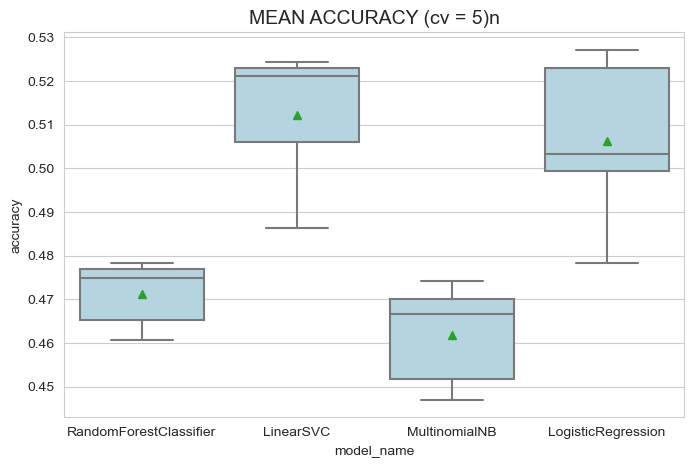

In [50]:
%%time
cv_df_tfidf = cross_validate_models(models,X_train_vectors_tfidf,y_train,cv=5)
plot_model_performance(cv_df_tfidf)

CPU times: user 52.9 s, sys: 2.4 s, total: 55.3 s
Wall time: 43.3 s


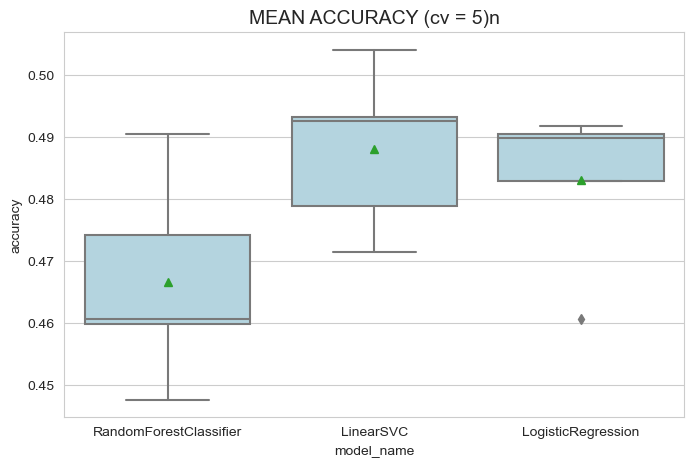

In [51]:
%%time
cv_df_w2v = cross_validate_models(models,X_train_vectors_w2v,y_train,cv=5)
plot_model_performance(cv_df_w2v)

CPU times: user 52.7 s, sys: 3.63 s, total: 56.3 s
Wall time: 31.4 s


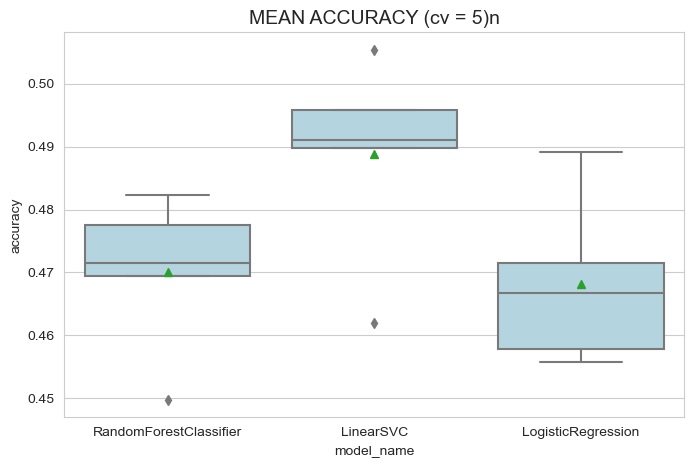

In [52]:
%%time
cv_df_se = cross_validate_models(models,X_train_vectors_se,y_train,cv=5)
plot_model_performance(cv_df_se)

In [53]:
best_model = LinearSVC()
best_model.fit(X_train_vectors_tfidf, y_train)
y_pred = best_model.predict(X_test_vectors_tfidf)

In [54]:
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df['REASON'].unique()))

                                     precision    recall  f1-score   support

Other questions about product usage       0.35      0.31      0.33        87
                              Other       0.40      0.47      0.43       155
          Blocked/defective readers       0.59      0.68      0.63       116
                        Bookkeeping       0.68      0.50      0.58        30
                         Pre-Signup       0.10      0.03      0.04        37
                    Fee negotiation       0.43      0.38      0.40         8
           Product setup/activation       0.54      0.62      0.57       117
             Other technical issues       0.50      0.53      0.51        95
                                 \N       1.00      0.98      0.99       147
      Profile/account/store closure       0.61      0.52      0.56        52
                             Signup       0.40      0.34      0.37        76

                           accuracy                           0.56       9

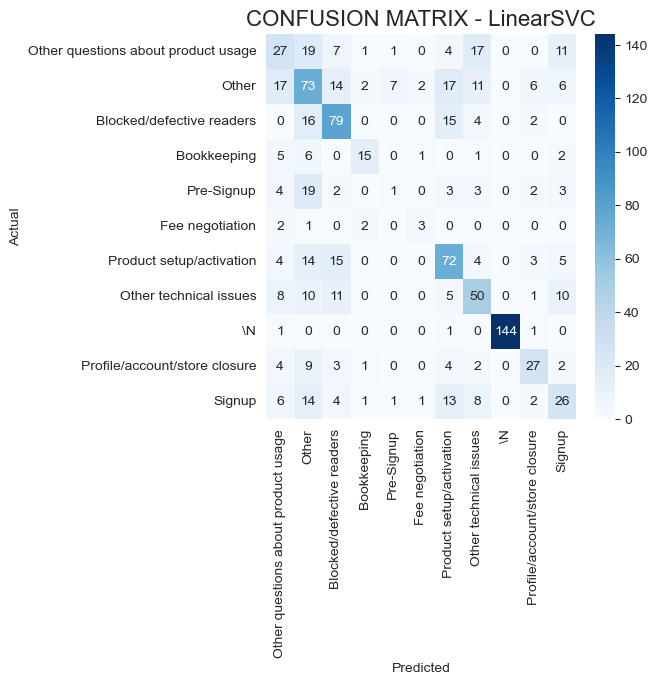

In [55]:
plot_confusion_matrix(y_test,y_pred,best_model, df)